In [1]:
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import cv2 as cv
import random
from PIL import Image
%matplotlib notebook

print(cv.__version__)

4.6.0


In [2]:
data_path = os.path.join(os.getcwd(), "Data", "30cm")

image_names = os.listdir(data_path)
print(image_names)
image_paths = [os.path.join(data_path, image_name) for image_name in image_names]
im_array = [(cv.imread(im_path, cv.IMREAD_GRAYSCALE)) for im_path in image_paths]

rows, cols = im_array[0].shape
div_factor = cols / 400 
dims = (int(cols / div_factor), int(rows / div_factor))

scaled_im_array = []

for i in range(len(im_array)):
    scaled_im_array.append(cv.resize(im_array[i], dims, interpolation=cv.INTER_AREA))

['IMG_2659.jpg', 'IMG_2660.jpg']


In [3]:
class QR_img_info:
    def __init__(self, img, index_george, index_jeff, QR_info, corners):
        self.img = img
        self.index_george = index_george
        self.index_jeff = index_jeff
        self.QR_info = QR_info
        self.corners = corners

In [4]:
N_MATCHES = 50
s = 4
N_RANSAC = 3000
INLIER_THRESHOLD = 0.1

# N_MATCHES = 300
# s = 4
# N_RANSAC = 1000
# INLIER_THRESHOLD = 0.5

QR_HEIGHT_CM = 5.9
GEORGE = 'Robot 1 (George)'
JEFF = 'Robot 2 (Jeff)'
QR_DIST_CM_TRUE = 30
DEBUG = False
PLOT_LINE = True
DOWNSIZE = False

In [5]:
# Provided code for plotting inlier matches between two images
def plot_inlier_matches(ax, img1, img2, inliers):
    """
    Plot the matches between two images according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')

# constructs matrix A from lecture, projects locations from left image 
# onto locations in right image
def construct_A(l_homo_coords, r_homo_coords):
    zero_T = np.zeros(3)
    A = np.empty((8,9))
    for i in range(s):
        x_T = l_homo_coords[i]
        row_1 = np.hstack((zero_T, x_T, -1 * r_homo_coords[i][1] * x_T))
        row_2 = np.hstack((x_T, zero_T, -1 * r_homo_coords[i][0] * x_T))
        A[2*i] = row_1
        A[2*i+1] = row_2
    return A

# convert 2D homogeneous coords to regular 2D coords
def homo_to_norm(homo_coords):
    return np.array((homo_coords[0] / homo_coords[2], homo_coords[1] / homo_coords[2]))

# warp a point using a homography matrix
def warp_point(normal_coords, homo_matrix):
    # convert coordinates to homogenous coordinates
    homo_coords = np.array(normal_coords + (1,))
    # compute Hx, projected coordinates of homo_coords
    proj_homo_coords = np.matmul(homo_matrix, homo_coords)
    # convert projected homo coordinates back to normal coordinates
    return homo_to_norm(proj_homo_coords) 

# compute inliers and avg residuals for given homography
def compute_inliers(putatives, l_kps, r_kps, homo_matrix, all_matches):
    num_inliers = 0
    total_residuals = 0.
    inliers = []
    # cycle through all putatives for inliers
    for i in range(len(putatives)):
        # normal coordinates for both points
        r_coords = r_kps[all_matches[i].trainIdx].pt
        l_coords = l_kps[all_matches[i].queryIdx].pt
        # warp point with homography matrix
        proj_l_coords = warp_point(l_coords, homo_matrix)
        # compute SSD between projected left coords and known right coords
        residual = np.sum((r_coords - proj_l_coords)**2)
        # if less than threshold, count it
        if residual < INLIER_THRESHOLD:
            num_inliers += 1
            total_residuals += residual
            # append inlier as 1D array of length 4 (leftcoords, rightcoords
            inliers.append(np.hstack((l_coords, r_coords)))    
    return np.array(inliers), total_residuals / num_inliers


# RANSAC PARAMETERS
def RANSAC(putatives, l_kps, r_kps, all_matches):
    # our return values
    best_num_inliers = 0
    best_avg_inlier_residual = 0
    best_homo_matrix = np.empty((3,3))
    best_inliers = []
    # iterate N_RANSAC times
    for i in range(N_RANSAC):
        # draw s(4) points at random 
        matches = random.sample(putatives, s)
        # matches are list of elements of form (x1, y1), (x2, y2)
        # translate to homogeneous coordinates
        coords_left = np.array([np.array(l_kps[matches[i].queryIdx].pt + (1,)) for i in range(s)])
        coords_right = np.array([np.array(r_kps[matches[i].trainIdx].pt + (1,)) for i in range(s)])
        # construct matrix A as described in lecture
        A = construct_A(coords_left, coords_right)
        # find solution for homography matrix H
        U_, s_, v_ = np.linalg.svd(A)
        min_s_val = v_[-1]
        homo_matrix = min_s_val.reshape((3,3))
        # use H to compute inliers
        inliers, avg_residual = compute_inliers(putatives, l_kps, r_kps, homo_matrix, all_matches)
        num_inliers = len(inliers)
        # update best homography
        if num_inliers > best_num_inliers:
            best_num_inliers = num_inliers
            best_avg_inlier_residual = avg_residual
            best_homo_matrix = homo_matrix
            best_inliers = inliers
    return best_inliers, best_avg_inlier_residual, best_homo_matrix

In [6]:
def get_RANSAC_matrix(img1, img2):
    # Initiate ORB detector
    orb = cv.ORB_create()
    # find the keypoints and descriptors with ORB
    kp1, des1 = orb.detectAndCompute(img1,None)
    kp2, des2 = orb.detectAndCompute(img2,None)

    # create BFMatcher object
    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

    # Match descriptors.
    all_matches = bf.match(des1,des2)
    # Sort them in the order of their distance.
    all_matches = sorted(all_matches, key = lambda x:x.distance)

    if(DEBUG):
        # Draw first 10 matches.
        img3 = cv.drawMatches(img1,kp1,img2,kp2,all_matches[:50],None)
        plt.imshow(img3),plt.show()

    putatives = all_matches[:N_MATCHES]
    # actual RANSAC calculation
    best_inliers, best_avg_inlier_residual, best_homo_matrix = RANSAC(putatives, kp1, kp2, all_matches)

    return best_inliers.T

In [7]:
def get_robot_indices(decoded_info):
     # find indices of george and jeff QR codes in QR detector responses
    index_george, index_jeff = -1, -1
    if GEORGE in decoded_info and JEFF in decoded_info:
        return decoded_info.index(GEORGE), decoded_info.index(JEFF)
    else:
        return (-1,-1)

In [8]:
# extract robot QR code info and append to data_matrix (or create data_matrix)
def get_full_data_matrix(data_matrix, img_info_1, img_info_2, div_factor):
    george_corners_1 = img_info_1.corners[img_info_1.index_george].T
    george_corners_2 = img_info_2.corners[img_info_1.index_george].T
    jeff_corners_1 = img_info_1.corners[img_info_1.index_jeff].T
    jeff_corners_2 = img_info_2.corners[img_info_2.index_jeff].T

    george_corners = np.vstack((george_corners_1, george_corners_2))
    jeff_corners = np.vstack((jeff_corners_1, jeff_corners_2))

    scaled_corners = np.hstack((george_corners, jeff_corners)) / div_factor

    # return coordinates stacked with data_matrix
    if data_matrix != []:
        return np.hstack((data_matrix, scaled_corners)) 
    else: # just the scaled corners
        return scaled_corners


In [9]:
"""
Find the matrix Q to eliminate the affine ambiguity using the method described on slide 32 of the lecture.
takes: and M from 
"""
def get_3d_reconstruction(data_matrix):
    means = np.mean(data_matrix, axis=1, keepdims=True)
    norm_matrix = data_matrix - means

    m2, n = norm_matrix.shape
    m = m2 // 2

    if(DEBUG):
        print("m: " + str(m))
        print("n: " + str(n))

    """
    Apply SVD to the 2M x N data matrix to express it as D = U @ W @ V' 
    (using NumPy notation) where U is a 2Mx3 matrix, W is a 3x3 matrix 
    of the top three singular values, and V is a Nx3 matrix. 
    Next, derive structure and motion matrices from the SVD
    """
    U, W, V_T = np.linalg.svd(norm_matrix)
    U_3 = U[:,:3]
    SIGMA_3 = np.diag(W[:3])
    VT_3 = V_T[:3]

    M = U_3 @ np.sqrt(SIGMA_3)
    S = np.sqrt(SIGMA_3) @ VT_3
    
    coeff = np.empty((4*m,6))
    vec = np.empty((4*m))
    for i in range(m):
        A = M[2*i:2*i+2]
        A11 = A[0][0]
        A12 = A[0][1]
        A13 = A[0][2]
        A21 = A[1][0]
        A22 = A[1][1]
        A23 = A[1][2]
        coeff[4*i]   = np.array([A11*A11, A11*A12, A11*A13, A12*A12, A12*A13, A13*A13])
        coeff[4*i+1] = np.array([A21*A11, A21*A12, A21*A13, A22*A12, A22*A13, A23*A13])
        coeff[4*i+2] = np.array([A11*A21, A11*A22, A11*A23, A12*A22, A12*A23, A13*A23])
        coeff[4*i+3] = np.array([A21*A21, A21*A22, A21*A23, A22*A22, A22*A23, A23*A23])
        vec[4*i]   = 1
        vec[4*i+1] = 0
        vec[4*i+2] = 0
        vec[4*i+3] = 1  

    x, residuals, rank, s = np.linalg.lstsq(coeff, vec)
    L = np.array([[x[0], x[1], x[2]], [x[1], x[3], x[4]], [x[2], x[4], x[5]]])
    Q = np.linalg.cholesky(L)
    MQ = M@Q
    QS = np.linalg.inv(Q)@S
    D = MQ@QS
    D_trans = D + means
    
    if(DEBUG):
        print("L:")
        print(L)
        print("Q:")
        print(Q)
    
    return MQ, QS, D_trans

Use matplotlib to display the 3D structure (in your report, you may want to include snapshots from several viewpoints to show the structure clearly). Discuss whether or not the reconstruction has an ambiguity.

In [10]:
# calculate distance between two QR codes given 3D coordinate array QS
def get_distance_and_centers(QS):
    # create sequences of corners for each shape (repeating the first corner again at the end)
    square_1 = np.c_[QS[:,-8:-4], QS[:,-8]]
    square_2 = np.c_[QS[:,-4:], QS[:,-4]]

    square_1_perimeter = 0
    square_2_perimeter = 0

    # loop through all pairs of corners to calculate total square perimeters
    for i in range(4):
        square_1_perimeter += np.linalg.norm(square_1[:,i]-square_1[:,i+1])
        square_2_perimeter += np.linalg.norm(square_2[:,i]-square_2[:,i+1])

    average_side_length = (square_1_perimeter + square_2_perimeter) / 8

    # calculate ratio of 3d distances to real world distance
    # now, we can use this to measure distances, take any distance in 3d and divide by this ratio to get CM
    ratio_3d_real = average_side_length / QR_HEIGHT_CM

    # now we calculate the center of both squares in 3d
    center_1 = np.mean(QS[:,-8:-4], axis=1)
    center_2 = np.mean(QS[:,-4:], axis=1)

    center_line = (center_1 + center_2) / 2

    distance_3d = np.linalg.norm(center_1-center_2)

    distance_real = distance_3d / ratio_3d_real
    

    print("Calculated 3-D Distance between squares in cm: " + str(distance_real))
    print("True 3-D distance between squares in cm: " + str(QR_DIST_CM_TRUE))
    
    if(PLOT_LINE):
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.scatter(QS[0][:-8], QS[1][:-8], QS[2][:-8])
        ax.scatter(QS[0][-8:-4], QS[1][-8:-4], QS[2][-8:-4], marker='o')
        ax.scatter(QS[0][-4:], QS[1][-4:], QS[2][-4:], marker='^')

        ax.plot([center_1[0], center_2[0]], [center_1[1], center_2[1]], [center_1[2], center_2[2]], marker = 'p', color='red')
        ax.text(center_line[0], center_line[1], center_line[2], "{:.2f}".format(distance_real) + "cm")

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        plt.show()
        
    return distance_real, center_1, center_2, center_line
    

Got one image
Got one image
Got one image
Got one image
Got one image
Got one image
Got one image
Got one image
Got one image
Got one image
Got one image
Got one image
Got one image
Got one image
Got one image
Got one image
Got one image
Got one image
Got one image
Got one image
Got two images
CALCULATING DISTANCE
Calculated 3-D Distance between squares in cm: 23.95346573330651
True 3-D distance between squares in cm: 30


C:\Users\oh_bo\AppData\Local\Temp\ipykernel_11612\2139039277.py:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if data_matrix != []:
C:\Users\oh_bo\AppData\Local\Temp\ipykernel_11612\94683563.py:49: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x, residuals, rank, s = np.linalg.lstsq(coeff, vec)


<IPython.core.display.Javascript object>


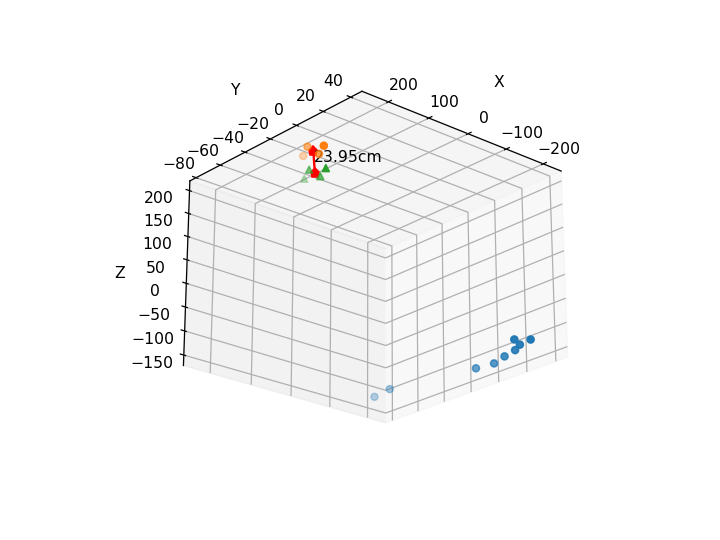

Got one image
Got two images
CALCULATING DISTANCE


LinAlgError: Matrix is not positive definite

In [11]:
camera_id_0 = 0
camera_id_1 = 1
delay = 1
window_name = 'OpenCV QR Code'

qcd = cv.QRCodeDetector()
cap1 = cv.VideoCapture(camera_id_0)
cap2 = cv.VideoCapture(camera_id_1)

img_1_shape = ()

img_info_1 = []
img_info_2 = []

while True:
    ret1, frame1 = cap1.read()
    ret2, frame2 = cap2.read()

    if ret1 and ret2:
        img_1_shape = frame1.shape
        img_2_shape = frame2.shape        
#         print("got both frames")
        
#         cv.imshow("image1", frame1)
#         cv.imshow("image2", frame2)
        
        img_1 = cv.cvtColor(frame1, cv.COLOR_BGR2GRAY)
        ret_1, decoded_info_1, corners_1, straight_qrcode_1 = qcd.detectAndDecodeMulti(img_1)
        index_george_1, index_jeff_1 = get_robot_indices(decoded_info_1)
        if index_george_1 != -1 and index_jeff_1 != -1:
            print("Got one image")
            img_2 = cv.cvtColor(frame2, cv.COLOR_BGR2GRAY)
            ret_2, decoded_info_2, corners_2, straight_qrcode_2 = qcd.detectAndDecodeMulti(img_2)
            index_george_2, index_jeff_2 = get_robot_indices(decoded_info_2)
            if index_george_2 != -1 and index_jeff_2 != -1:
                img_info_1 = QR_img_info(img_1, index_george_1, index_jeff_1, decoded_info_1, corners_1)
                img_info_2 = QR_img_info(img_2, index_george_2, index_jeff_2, decoded_info_2, corners_2)
                print("Got two images")
                
                if(DOWNSIZE):
                    rows, cols = img_shape
                    div_factor = cols / 400 
                    dims = (int(cols / div_factor), int(rows / div_factor))
                    img_info_1.img = cv.resize(img_info_1.img, dims, interpolation=cv.INTER_AREA)
                    img_info_2.img = cv.resize(img_info_2.img, dims, interpolation=cv.INTER_AREA)

                print("CALCULATING DISTANCE")
                # calculate data matrix
                data_matrix = []
                # first perform RANSAC if applicable
                if(RANSAC):
                    data_matrix = get_RANSAC_matrix(img_info_1.img, img_info_2.img)
                # then append QR coordinates
                data_matrix = get_full_data_matrix(data_matrix, img_info_1, img_info_2, div_factor)
                # perform 3d reconstruction from data_matrix
                MQ, QS, D_trans = get_3d_reconstruction(data_matrix)
                # calculate real world distances
                distance_real, center_1, center_2, center_line = get_distance_and_centers(QS)


    if cv.waitKey(delay) & 0xFF == ord('q'):
        break

cv.destroyWindow(window_name)